In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import os
import datetime as dt
import xgboost as xgb
from sklearn.svm import OneClassSVM
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [84]:
sns.set_context("poster") 
plt.style.use('seaborn-poster')

# Install XGBoost

In [19]:
# !pip install xgboost

# Data cleaning

In [85]:
resono_df = pd.read_csv('resono_2020_2022.csv', index_col=0)

In [86]:
# resono_df

In [171]:
def clean_resono(df, merge=True):
    '''
    ~~Probably defunct once we merge the datasets~~
    Quick cleaning of the Resono data
    
    :df: Dataframe to clean
    :merge: True if Noord/Zuid and Oost/West need to be merged (default = True)
    
    Returns a cleaned Dataframe
    '''
    df.loc[(df.Location == 'Westergasfabriek'),'Location'] = 'Westerpark'
    df['End'] = pd.to_datetime(df['End'])
    
    if merge == True:
        # Merge Noord-Zuid & Oost-West into one location
        df.loc[df.Location.str.contains('Rembrandtpark'), 'Location'] = 'Rembrandtpark'
        df.loc[df.Location.str.contains('Vondelpark'), 'Location'] = 'Vondelpark'
    
    df = df.rename(columns = {'End' : 'Datetime',
                              'End_Dates' : 'Date',
                              'End_Time' : 'Time'})
    df = df.set_index('Datetime')
    return df
    
data_clean = clean_resono(resono_df)
data_clean

,Location,Visits,Date,Time
Datetime,,,,
2020-09-30 00:15:00,Erasmuspark,71,2020-09-30,00:15:00
2020-09-30 00:30:00,Erasmuspark,56,2020-09-30,00:30:00
2020-09-30 00:45:00,Erasmuspark,41,2020-09-30,00:45:00
2020-09-30 01:00:00,Erasmuspark,55,2020-09-30,01:00:00
2020-09-30 01:15:00,Erasmuspark,33,2020-09-30,01:15:00
...,...,...,...,...
2022-01-06 13:45:00,Westerpark,75,2022-01-06,13:45:00
2022-01-06 14:00:00,Westerpark,77,2022-01-06,14:00:00
2022-01-06 14:15:00,Westerpark,69,2022-01-06,14:15:00


In [172]:
list(set(data_clean.Location))

['Vondelpark',
 'Westerpark',
 'Oosterpark',
 'Sarphatipark',
 'Rembrandtpark',
 'Erasmuspark']

# Data preprocessing

In [170]:
def remove_outliers(df, gamma=0.01, nu=0.03):
    '''
    Remove outliers for each location with a One-Class SVM.
    
    :df: Dataframe to perform outlier detection on
    :gamma: Value of the kernel coefficient for ‘rbf’ (default = 0.01)
    :nu: Percentage of the data to be classified as outliers (default = 0.03)
    
    Returns
    :df_detected: Dataframe with the outliers replaced by NaN
    :outlier_index: List of the indexes of the outliers (used for plotting the outliers, probably 
                                                         not necessary for final product)
    '''
    model = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)
    df = df.reset_index()
    
    for loc in list(set(df.Location)):
        dt = df[(df.Location == loc)]
        dt_detected = dt.copy()

        scaler = preprocessing.StandardScaler()
        dt_scaled = scaler.fit_transform(dt['Visits'].values.reshape(-1,1))

        fit = model.fit(dt_scaled)
        pred = fit.predict(dt_scaled)
        outlier_index = np.where(pred == -1)
        idx = dt.iloc[outlier_index].index
        df.loc[idx, 'Visits'] = np.nan
        
    df = df.set_index('Datetime')
    return df

test = remove_outliers(data_clean)
test.head(15)

,Location,Visits,Date,Time
Datetime,,,,
2020-09-30 00:15:00,Erasmuspark,71.0,2020-09-30,00:15:00
2020-09-30 00:30:00,Erasmuspark,56.0,2020-09-30,00:30:00
2020-09-30 00:45:00,Erasmuspark,41.0,2020-09-30,00:45:00
2020-09-30 01:00:00,Erasmuspark,55.0,2020-09-30,01:00:00
2020-09-30 01:15:00,Erasmuspark,33.0,2020-09-30,01:15:00
2020-09-30 01:30:00,Erasmuspark,27.0,2020-09-30,01:30:00
2020-09-30 01:45:00,Erasmuspark,53.0,2020-09-30,01:45:00
2020-09-30 02:00:00,Erasmuspark,31.0,2020-09-30,02:00:00
2020-09-30 02:15:00,Erasmuspark,24.0,2020-09-30,02:15:00


In [174]:
# Check if everything works with some outliers from Erasmuspark
outliers = [10, 11, 1532, 1533, 1534, 1535, 1536, 1537, 1631, 1632]
test.iloc[outliers]

,Location,Visits,Date,Time
Datetime,,,,
2020-09-30 02:45:00,Erasmuspark,NaN,2020-09-30,02:45:00
2020-09-30 03:00:00,Erasmuspark,NaN,2020-09-30,03:00:00
2020-10-16 03:15:00,Erasmuspark,NaN,2020-10-16,03:15:00
2020-10-16 03:30:00,Erasmuspark,NaN,2020-10-16,03:30:00
2020-10-16 03:45:00,Erasmuspark,NaN,2020-10-16,03:45:00
2020-10-16 04:00:00,Erasmuspark,NaN,2020-10-16,04:00:00
2020-10-16 04:15:00,Erasmuspark,NaN,2020-10-16,04:15:00
2020-10-16 04:30:00,Erasmuspark,NaN,2020-10-16,04:30:00
2020-10-17 04:15:00,Erasmuspark,NaN,2020-10-17,04:15:00


In [192]:
def interpolate_df(df, backfill=False):
    '''
    Interpolate the NaN values in the dataframe with either backfilling or linear interpolation.
    
    :df: Dataframe to be interpolated
    :backfill: Bool, if true, interpolate with backfilling, otherwise use linear interpolation (default = False)
    
    Returns a Dataframe with interpolated values
    '''
    df_int = df.copy()
    dt = df['Visits']
    dt_int = dt.copy()
    
    if backfill == True:
        dt_int = dt_int.backfill()
        
    else:
        dt_int = dt_int.interpolate()

    df_int['Visits'] = dt_int   
    return df_int

test_int = interpolate_df(test, backfill=False)
test_int.iloc[outliers]

,Location,Visits,Date,Time
Datetime,,,,
2020-09-30 02:45:00,Erasmuspark,32.666667,2020-09-30,02:45:00
2020-09-30 03:00:00,Erasmuspark,42.333333,2020-09-30,03:00:00
2020-10-16 03:15:00,Erasmuspark,22.714286,2020-10-16,03:15:00
2020-10-16 03:30:00,Erasmuspark,32.428571,2020-10-16,03:30:00
2020-10-16 03:45:00,Erasmuspark,42.142857,2020-10-16,03:45:00
2020-10-16 04:00:00,Erasmuspark,51.857143,2020-10-16,04:00:00
2020-10-16 04:15:00,Erasmuspark,61.571429,2020-10-16,04:15:00
2020-10-16 04:30:00,Erasmuspark,71.285714,2020-10-16,04:30:00
2020-10-17 04:15:00,Erasmuspark,66.333333,2020-10-17,04:15:00


In [177]:
# no_outliers = data_aug.copy()
# no_outliers['Visits'] = test_int['Visits']
# no_outliers.iloc[outliers]

In [178]:
def smooth_df(df, N=3):
    '''
    Smooth the Visits data with a rolling average to remove false peaks in the data
    
    :df: Dataframe to be smoothed
    :N: Size of the moving window (default = 3)
    
    Returns a smoothed Dataframe
    '''
    df_smooth = df.copy()
    dt = df['Visits']
    df_smooth['Visits'] = dt.rolling(N).mean()
    
    begin_vals = df.iloc[:N-1]
    df_smooth.update(begin_vals)
        
    return df_smooth

data_smooth = smooth_df(test_int)
data_smooth

,Location,Visits,Date,Time
Datetime,,,,
2020-09-30 00:15:00,Erasmuspark,71.000000,2020-09-30,00:15:00
2020-09-30 00:30:00,Erasmuspark,56.000000,2020-09-30,00:30:00
2020-09-30 00:45:00,Erasmuspark,56.000000,2020-09-30,00:45:00
2020-09-30 01:00:00,Erasmuspark,50.666667,2020-09-30,01:00:00
2020-09-30 01:15:00,Erasmuspark,43.000000,2020-09-30,01:15:00
...,...,...,...,...
2022-01-06 13:45:00,Westerpark,86.000000,2022-01-06,13:45:00
2022-01-06 14:00:00,Westerpark,80.666667,2022-01-06,14:00:00
2022-01-06 14:15:00,Westerpark,73.666667,2022-01-06,14:15:00


In [193]:
def add_time_vars(data, onehot=True):
    '''
    Adds columns for the month and weekday, and also the one-hot encoding or the cyclical versions of those features.

    :data: Dataframe that contains the a column with the datetime
    :onehot: Use onehot encoding if true and cyclical features if false (default = True)
    
    Returns a Dataframe with either the one-hot encoding or the sine and cosine of the month, weekday and time added
    '''
    data = data.reset_index()
    if onehot == True:
        years = pd.Categorical(data['Datetime'].dt.year)
        data['Month'] = pd.Categorical(data['Datetime'].dt.month)
        data['Weekday'] = pd.Categorical(data['Datetime'].dt.weekday)
        data['Hour'] =  pd.Categorical(data['Datetime'].dt.hour)
        data['Minute'] =  pd.Categorical(data['Datetime'].dt.minute)

        year_dummies = pd.get_dummies(years, prefix='Year_')
        month_dummies = pd.get_dummies(data[['Month']], prefix='Month_')
        weekday_dummies = pd.get_dummies(data[['Weekday']], prefix='Weekday_')
        hour_dummies = pd.get_dummies(data[['Hour']], prefix='Hour_')
        minute_dummies = pd.get_dummies(data[['Minute']], prefix='Minute_')
        
        data = data.merge(year_dummies, left_index = True, right_index = True)
        data = data.merge(month_dummies, left_index = True, right_index = True)
        data = data.merge(weekday_dummies, left_index = True, right_index = True)
        data = data.merge(hour_dummies, left_index = True, right_index = True)
        data = data.merge(minute_dummies, left_index = True, right_index = True)
        
    else: 
        dates = data['Date'].values
        weekdays = []
        months = []
        hours = []
        minutes = []

        for d in dates:
            year, month, day = (int(x) for x in d.split('-'))
            ans = dt.date(year, month, day)
            weekdays.append(ans.isocalendar()[2])
            months.append(month)

        for t in data['Time']:
            hour, minute, second = (int(x) for x in t.split(':'))
            hours.append(hour)
            minutes.append(minute)
        
        data['Weekday'] = weekdays
        data['Month'] = months
        data['Hour'] = hours
        data['Minute'] = minutes
        data['Weekday_sin'] = np.sin(data['Weekday'] * (2 * np.pi / 7))
        data['Weekday_cos'] = np.cos(data['Weekday'] * (2 * np.pi / 7))
        data['Month_sin'] = np.sin(data['Month'] * (2 * np.pi / 12))
        data['Month_cos'] = np.cos(data['Month'] * (2 * np.pi / 12))
        data['Hour_sin'] = np.sin(data['Hour'] * (2 * np.pi / 24))
        data['Hour_cos'] = np.cos(data['Hour'] * (2 * np.pi / 24))
        data['Minute_sin'] = np.sin(data['Minute'] * (2 * np.pi / 60))
        data['Minute_cos'] = np.cos(data['Minute'] * (2 * np.pi / 60))
        
    data = data.set_index('Datetime')
    return data

data_aug = add_time_vars(data_smooth, onehot=True)
data_aug

,Location,Visits,Date,Time,Month,Weekday,Hour,Minute,Year__2020,Year__2021,...,Hour__18,Hour__19,Hour__20,Hour__21,Hour__22,Hour__23,Minute__0,Minute__15,Minute__30,Minute__45
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-09-30 00:15:00,Erasmuspark,71.000000,2020-09-30,00:15:00,9,2,0,15,1,0,...,0,0,0,0,0,0,0,1,0,0
2020-09-30 00:30:00,Erasmuspark,56.000000,2020-09-30,00:30:00,9,2,0,30,1,0,...,0,0,0,0,0,0,0,0,1,0
2020-09-30 00:45:00,Erasmuspark,56.000000,2020-09-30,00:45:00,9,2,0,45,1,0,...,0,0,0,0,0,0,0,0,0,1
2020-09-30 01:00:00,Erasmuspark,50.666667,2020-09-30,01:00:00,9,2,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2020-09-30 01:15:00,Erasmuspark,43.000000,2020-09-30,01:15:00,9,2,1,15,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06 13:45:00,Westerpark,86.000000,2022-01-06,13:45:00,1,3,13,45,0,0,...,0,0,0,0,0,0,0,0,0,1
2022-01-06 14:00:00,Westerpark,80.666667,2022-01-06,14:00:00,1,3,14,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2022-01-06 14:15:00,Westerpark,73.666667,2022-01-06,14:15:00,1,3,14,15,0,0,...,0,0,0,0,0,0,0,1,0,0


# Predictions with XGBoost

In [194]:
# data_aug.columns.to_list()[8:]

['Year__2020',
 'Year__2021',
 'Year__2022',
 'Month__1',
 'Month__2',
 'Month__3',
 'Month__4',
 'Month__5',
 'Month__6',
 'Month__7',
 'Month__8',
 'Month__9',
 'Month__10',
 'Month__11',
 'Month__12',
 'Weekday__0',
 'Weekday__1',
 'Weekday__2',
 'Weekday__3',
 'Weekday__4',
 'Weekday__5',
 'Weekday__6',
 'Hour__0',
 'Hour__1',
 'Hour__2',
 'Hour__3',
 'Hour__4',
 'Hour__5',
 'Hour__6',
 'Hour__7',
 'Hour__8',
 'Hour__9',
 'Hour__10',
 'Hour__11',
 'Hour__12',
 'Hour__13',
 'Hour__14',
 'Hour__15',
 'Hour__16',
 'Hour__17',
 'Hour__18',
 'Hour__19',
 'Hour__20',
 'Hour__21',
 'Hour__22',
 'Hour__23',
 'Minute__0',
 'Minute__15',
 'Minute__30',
 'Minute__45']

In [195]:
def predict(data, location, pred_params, N_boost=100):
    '''
    Predict the amount of visits using XGBoost
    
    :data: Dataframe with all the data
    :location: The location of the park to make predictions for
    :pred_params: A list of the names of the predictor variables
    :N_boost: Number of boost rounds during training (default = 100)
    
    Returns nothing (yet)
    '''
    # Select data for a specific park
    data = data[data['Location'] == location]

    # Split the data into input and output variables
    X = data[pred_params]
    y = data['Visits']

    # Split the data into test and train sets
    train_X, test_X, train_y, test_y = train_test_split(X, y,
                          test_size = 0.3, random_state = 123)

    # Convert test and train set to DMatrix objects
    train_dmatrix = xgb.DMatrix(data = train_X, label = train_y)
    test_dmatrix = xgb.DMatrix(data = test_X, label = test_y)
    
    # Set parameters for base learner
    params = {
        'booster': 'gblinear',
#         'colsample_bynode': 0.8,
        'learning_rate': 1,
#         'max_depth': 15,
#         'num_parallel_tree': 100,
        'objective': 'reg:squarederror',
#         'subsample': 0.8,
#         'tree_method': 'gpu_hist'
    }

    # Fit the data and make predictions
    model = xgb.train(params = params, dtrain = train_dmatrix, num_boost_round = N_boost)
    pred = model.predict(test_dmatrix)
    predictions = pd.DataFrame({'Predicted visitors': pred,
                                'Actual visitors': test_y})
    predictions = predictions.clip(lower=0)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_y, predictions['Predicted visitors']))
    mae = mean_absolute_error(test_y, predictions['Predicted visitors'])
    print(location)
    print("RMSE : % f" %(rmse))
    print("MAE : % f" %(mae))
    return predictions
    

predictor_cols = data_aug.columns.to_list()[8:]
for park in list(set(data_aug.Location)):
    predictions = predict(data_aug, park, predictor_cols, 1000)

Vondelpark
RMSE :  289.559127
MAE :  198.822972
Westerpark
RMSE :  81.356476
MAE :  47.428861
Oosterpark
RMSE :  248.759661
MAE :  171.754382
Sarphatipark
RMSE :  267.263542
MAE :  179.925397
Rembrandtpark
RMSE :  510.448591
MAE :  406.127784
Erasmuspark
RMSE :  219.164519
MAE :  135.259617


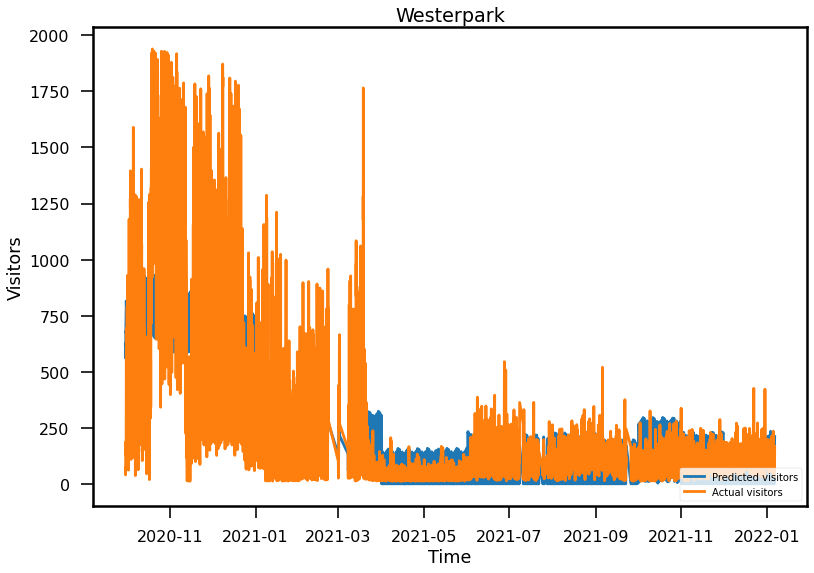

In [196]:
def create_plot(data, file_name):
    #Plots the predictions.
    plt.plot(data['Predicted visitors'], label='Predicted visitors')
    plt.plot(data['Actual visitors'], label='Actual visitors')
    plt.xlabel('Time')
    plt.ylabel('Visitors')
    plt.legend(loc='lower right', prop={'size': 10})
#     plt.savefig('images/'+file_name)
    plt.title(file_name)
    plt.show()
    
create_plot(predictions.sort_index(), 'Westerpark')